In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from agent.workflow_tools import classify,summarize,validate_requirements,get_engineer_with_lowest_load,create_ticket,route_by_classification,auto_response,send_email

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [3]:
llm = ChatGroq(
    model_name="openai/gpt-oss-120b",   # or "llama3-70b-8192"
    groq_api_key=os.getenv("GROQ_API_KEY"),
    temperature=0.2
)

In [7]:
tools = [classify]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", """
        You are a Dispatcher Agent.
        Rules:
        - Create Ticket when there is an incident and the input in not a follow_up or a query.
        - Ask clarification if severity is unclear
            
        If you are unclear ask the user for clarification and end your reasoning.
        Always respond to the user either with clarification questions or the steps you took till now or both.
"""),
    ("human", "{input}")
])

chain = prompt | llm_with_tools

response = chain.invoke({
    "input": "Hello operations team , the gross sales margin in the consolidated sales report are not correct when i compare it with the SAP system, could you please check on this ASAP. This is quiet urgent since the Director needs the sales figure in this closing period. "
})

In [14]:
response

AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to decide if this is an incident. It\'s about gross sales margin discrepancy, urgent. It\'s not a follow_up or query, it\'s an incident. Need to create ticket. Need severity: urgent. Could be "high". The user says "quiet urgent". So severity is high. We need to fill fields: assigned_to null, classification category INCIDENT_ANOMALY, confidence 1.0, severity "HIGH". sub_category maybe "Sales Report Discrepancy". extracted_entities maybe include "gross sales margin", "consolidated sales report", "SAP system". summary: "Gross sales margin discrepancy in consolidated sales report compared to SAP". raw_input Title? Not provided; Title maybe empty. Use Body as given. status maybe "OPEN". next_action maybe "Investigate discrepancy". response_message maybe null. ticket_id null. lastUpdateTime current timestamp? Could set to now. source maybe "User". Let\'s create ticket.', 'tool_calls': [{'id': 'fc_7b114aa5-e8f4-4413-96ce-6

In [15]:
print(response.additional_kwargs['reasoning_content'])

We need to decide if this is an incident. It's about gross sales margin discrepancy, urgent. It's not a follow_up or query, it's an incident. Need to create ticket. Need severity: urgent. Could be "high". The user says "quiet urgent". So severity is high. We need to fill fields: assigned_to null, classification category INCIDENT_ANOMALY, confidence 1.0, severity "HIGH". sub_category maybe "Sales Report Discrepancy". extracted_entities maybe include "gross sales margin", "consolidated sales report", "SAP system". summary: "Gross sales margin discrepancy in consolidated sales report compared to SAP". raw_input Title? Not provided; Title maybe empty. Use Body as given. status maybe "OPEN". next_action maybe "Investigate discrepancy". response_message maybe null. ticket_id null. lastUpdateTime current timestamp? Could set to now. source maybe "User". Let's create ticket.


In [8]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [ ]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)

## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
response=graph.invoke({"messages":"what is machine learning/"})

In [ ]:
##ReACT Agent Architecture

In [52]:
llm = ChatGroq(
    model_name="openai/gpt-oss-120b",   # or "llama3-70b-8192"
    groq_api_key=os.getenv("GROQ_API_KEY"),
    temperature=0.2
)

In [53]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [75]:
def get_incident_updates(ticket_number:str) -> str:
    """This Function give us the engineer comments and progress on the incident ticket"""
    return "In Progress"
    pass

def create_ticket(RawInput:str) -> str:
    """This function creates a new ticket an assigns it to an engineer and returns the ticket number"""
    return {"Ticek_Number" : '12435',"Engineer_Name":"Pratik Surule"}


In [76]:
tools = [get_incident_updates,create_ticket]
llm_with_tool=llm.bind_tools(tools)

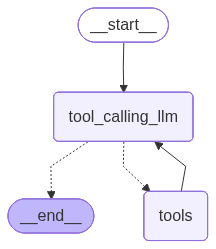

In [91]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memorysaver = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    prompt = ChatPromptTemplate.from_messages([
    ("system", """
        You are a Dispatcher Agent.
        Rules:
        - Create Ticket when there is an incident and the input in not a follow_up or a query.
        - Ask clarification if severity is unclear
        - Inform the user about the Ticket Number and Engineer assigned to the ticket if there is an incident detected and a ticket has been created
            
        If you are unclear ask the user for clarification and end your reasoning.
        Always respond to the user either with clarification questions or the steps you took till now or both.
    """),
        ("human", "{input}")
    ])

    chain = prompt | llm_with_tool

    return {"messages":[chain.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memorysaver)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
config = {"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"Hi My name is abhishek"},config=config)


In [ ]:
response = graph.invoke({"messages":"I am facing issues in PowerBI"},config=config)
response

{'messages': [HumanMessage(content='Hi My name is abhishek', additional_kwargs={}, response_metadata={}, id='65d4fe57-bd92-463c-9229-ce59dda5e93f'),
  AIMessage(content='Hello Abhishek! How can I assist you today?', additional_kwargs={'reasoning_content': 'We have a user message: "Hi My name is abhishek". No incident described. It\'s just greeting. According to rules: Create Ticket when there is an incident and the input is not a follow_up or a query. Here no incident. So we should respond appropriately. Possibly ask if they need assistance. Since no incident, we can just greet back. No ticket. So respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 314, 'total_tokens': 416, 'completion_time': 0.210777923, 'completion_tokens_details': {'reasoning_tokens': 81}, 'prompt_time': 0.013179755, 'prompt_tokens_details': None, 'queue_time': 0.049951515, 'total_time': 0.223957678}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890

In [ ]:
response = graph.invoke({"messages":"I am currently observing that the gross sales has risen drastically for SEFPRO project in PowerBi"},config=config)
response

{'messages': [HumanMessage(content='Hi My name is abhishek', additional_kwargs={}, response_metadata={}, id='8b56d042-217d-489d-855c-19be61026957'),
  AIMessage(content='Hello Abhishek! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user says "Hi My name is abhishek". No incident described. It\'s just greeting. According to rules: Create Ticket when there is an incident and input is not a follow_up or query. This is not an incident. So we should respond appropriately. Possibly ask how can I help. No ticket. So respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 313, 'total_tokens': 402, 'completion_time': 0.186064833, 'completion_tokens_details': {'reasoning_tokens': 68}, 'prompt_time': 0.039252648, 'prompt_tokens_details': None, 'queue_time': 0.054266131, 'total_time': 0.225317481}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'stop', '

In [85]:
response = graph.invoke({"messages":"The Severity is high since it is directly impacting the closing period business decisions by the c-suite and i want to resolve this incident asap"},config=config)
response

{'messages': [HumanMessage(content='Hi My name is abhishek', additional_kwargs={}, response_metadata={}, id='8b56d042-217d-489d-855c-19be61026957'),
  AIMessage(content='Hello Abhishek! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user says "Hi My name is abhishek". No incident described. It\'s just greeting. According to rules: Create Ticket when there is an incident and input is not a follow_up or query. This is not an incident. So we should respond appropriately. Possibly ask how can I help. No ticket. So respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 313, 'total_tokens': 402, 'completion_time': 0.186064833, 'completion_tokens_details': {'reasoning_tokens': 68}, 'prompt_time': 0.039252648, 'prompt_tokens_details': None, 'queue_time': 0.054266131, 'total_time': 0.225317481}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'stop', '

In [87]:
response = graph.invoke({"messages":"Is there any update on the ticket yet ?"},config=config)
response

{'messages': [HumanMessage(content='Hi My name is abhishek', additional_kwargs={}, response_metadata={}, id='8b56d042-217d-489d-855c-19be61026957'),
  AIMessage(content='Hello Abhishek! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user says "Hi My name is abhishek". No incident described. It\'s just greeting. According to rules: Create Ticket when there is an incident and input is not a follow_up or query. This is not an incident. So we should respond appropriately. Possibly ask how can I help. No ticket. So respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 313, 'total_tokens': 402, 'completion_time': 0.186064833, 'completion_tokens_details': {'reasoning_tokens': 68}, 'prompt_time': 0.039252648, 'prompt_tokens_details': None, 'queue_time': 0.054266131, 'total_time': 0.225317481}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'stop', '

In [86]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is abhishek
================================== Ai Message ==================================

Hello Abhishek! How can I assist you today?
================================ Human Message =================================

I am currently observing that the gross sales has risen drastically for SEFPRO project in PowerBi
================================== Ai Message ==================================

I’m glad you reached out. To make sure we handle this properly, could you let me know how severe you consider the sudden rise in gross sales for the SEFPRO project to be (e.g., critical, high, medium, low)? Any additional details you can share will also help us create the appropriate ticket.
================================ Human Message =================================

The Severity is high since it is directly impacting the closing period business decisions by the c-suite and i want to resolve this 

In [73]:
response = graph.invoke({"messages":"Is there any update on the above ticket ?"},config=config)


In [74]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is abhishek
================================== Ai Message ==================================

Hello Abhishek! How can I assist you today?
================================ Human Message =================================

I am currently observing that the gross sales has risen drastically for SEFPRO project in PowerBi
================================== Ai Message ==================================

I’m glad you brought this to our attention.  
Could you let me know how severe the impact is (e.g., low, medium, high) and any additional details such as the time period you noticed the spike and the effect it’s having on your operations? This will help me create the appropriate ticket for you.
================================ Human Message =================================

The Severity is high since it is directly impacting the closing period business decisions by the c-suite and i want to resolve th

In [38]:
response = graph.invoke({"messages":"Whats my name ?"},config=config)

In [39]:
response

{'messages': [HumanMessage(content='Hi My name is abhishek', additional_kwargs={}, response_metadata={}, id='74488f43-545a-4988-99c6-ff85bfcfe3b5'),
  AIMessage(content='Hello Abhishek! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user just says "Hi My name is abhishek". Probably we should greet them. No need to call any function.'}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 171, 'total_tokens': 219, 'completion_time': 0.100051516, 'completion_tokens_details': {'reasoning_tokens': 27}, 'prompt_time': 0.00734074, 'prompt_tokens_details': None, 'queue_time': 0.049947819, 'total_time': 0.107392256}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b7d3e-b241-7741-a6c9-943184ffbd90-0', usage_metadata={'input_tokens': 171, 'output_tokens': 48, 'total_tokens': 219, 'output_token_details': 

In [40]:
config = {"configurable":{"thread_id":"2"}}
response = graph.invoke({"messages":"What is my name"},config=config)

In [41]:
response

{'messages': [HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='eaf27e0e-e3ed-474f-a547-fc9cac5865ce'),
  AIMessage(content='I don’t have any information about your name. Could you let me know what you’d like to be called?', additional_kwargs={'reasoning_content': 'The user asks "What is my name". We have no prior context. We cannot know the user\'s name. We should respond that we don\'t have that info. Possibly ask for clarification.'}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 168, 'total_tokens': 238, 'completion_time': 0.148435515, 'completion_tokens_details': {'reasoning_tokens': 38}, 'prompt_time': 0.008635079, 'prompt_tokens_details': None, 'queue_time': 0.04996354, 'total_time': 0.157070594}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b7d3e-d5e8-7e71-8142-254287

In [51]:
config = {"configurable":{"thread_id":"3"}}
response=graph.invoke({"messages":"Give me the recent updates in Ticket INCSD:4562143"},config = config)
for m in response['messages']:
    m.pretty_print()

NameError: name 'llm_with_tools' is not defined

In [44]:
config = {"configurable":{"thread_id":"4"}}
response=graph.invoke({"messages":"Could you create a new ticket on this incident"},config = config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Could you create a new ticket on this incident
================================== Ai Message ==================================

Sure thing! Could you please provide a brief description of the incident (or any relevant details) that you’d like included in the ticket? This will help me create an accurate ticket for you.


In [45]:
response=graph.invoke({"messages":"The gross sales margin in the consolidated sales report are not correct when i compare it with the SAP system, could you please check on this ASAP. This is quiet urgent since the Director needs the sales figure in this closing period."},config = config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Could you create a new ticket on this incident
================================== Ai Message ==================================

Sure thing! Could you please provide a brief description of the incident (or any relevant details) that you’d like included in the ticket? This will help me create an accurate ticket for you.
================================ Human Message =================================

The gross sales margin in the consolidated sales report are not correct when i compare it with the SAP system, could you please check on this ASAP. This is quiet urgent since the Director needs the sales figure in this closing period.
================================== Ai Message ==================================
Tool Calls:
  create_ticket (fc_fb0b9f3b-7a6b-45a1-9d3d-8729ef432263)
 Call ID: fc_fb0b9f3b-7a6b-45a1-9d3d-8729ef432263
  Args:
    RawInput: The gross sales margin in the consolidated sales report i

In [48]:
response=graph.invoke({"messages":"what is the ticket number that you created ? "},config = config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Could you create a new ticket on this incident
================================== Ai Message ==================================

Sure thing! Could you please provide a brief description of the incident (or any relevant details) that you’d like included in the ticket? This will help me create an accurate ticket for you.
================================ Human Message =================================

The gross sales margin in the consolidated sales report are not correct when i compare it with the SAP system, could you please check on this ASAP. This is quiet urgent since the Director needs the sales figure in this closing period.
================================== Ai Message ==================================
Tool Calls:
  create_ticket (fc_fb0b9f3b-7a6b-45a1-9d3d-8729ef432263)
 Call ID: fc_fb0b9f3b-7a6b-45a1-9d3d-8729ef432263
  Args:
    RawInput: The gross sales margin in the consolidated sales report i

In [49]:
response=graph.invoke({"messages":"Could you give me any new updates in this ticket ?"},config = config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Could you create a new ticket on this incident
================================== Ai Message ==================================

Sure thing! Could you please provide a brief description of the incident (or any relevant details) that you’d like included in the ticket? This will help me create an accurate ticket for you.
================================ Human Message =================================

The gross sales margin in the consolidated sales report are not correct when i compare it with the SAP system, could you please check on this ASAP. This is quiet urgent since the Director needs the sales figure in this closing period.
================================== Ai Message ==================================
Tool Calls:
  create_ticket (fc_fb0b9f3b-7a6b-45a1-9d3d-8729ef432263)
 Call ID: fc_fb0b9f3b-7a6b-45a1-9d3d-8729ef432263
  Args:
    RawInput: The gross sales margin in the consolidated sales report i